In [51]:
%load_ext autoreload
%autoreload 2

import sklearn
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy import interpolate
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(1, os.path.join(sys.path[0], ".."))
sys.path.append('../../')
from reproduction.pipeline.load import load_data
from reproduction import analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
def gridsearch(start, step, stop, max_samples=5000, sample_steps=4):
    with open(ENCODER_DEF,"r") as f:
            encoder = tf.keras.models.model_from_json(f.read())
    encoder.load_weights(ENCODER_WEIGHTS)
    
    samples = np.logspace(np.log10(start+2), np.log10(max_samples), num=sample_steps).astype(int)
    search_results = [] # Force initialization
    # iterate on sampling 
    for i in samples:
        data = analysis.AEData(load_data(DATA, encoder.input_shape[1:]), n=i)
        data.add_encoder(encoder)
        
        # iterate on clustering
        for j in range(start, stop, step):
            if i/j > 2: # Agglomerative clustering must have leaves with at least 2 elements
                print('Samples: ', i,' Clusters: ',j)
                N_CLUSTERS = j
                ag1 = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(data.encs[:int(i/2)])
                ag2 = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(data.encs)
                minfo = sklearn.metrics.adjusted_mutual_info_score(ag1, ag2[:int(i/2)])
                search_results.append((i, N_CLUSTERS, minfo))
                print('Mutual information: ', minfo)
    return search_results
    

In [47]:
DATA = "/project/foster/clouds/data/2015_05/*.tfrecord"
ENCODER_DEF = "/home/rlourenco/rdcep_clouds/output/m9-22_oceans/encoder.json"
ENCODER_WEIGHTS = "/home/rlourenco/rdcep_clouds/output/m9-22_oceans/encoder.h5"
# N_CLUSTERS = 10

In [48]:
result = gridsearch(2,1,40,max_samples=10000, sample_steps=5)

Samples:  28  Clusters:  2
Mutual information:  1.0
Samples:  28  Clusters:  3
Mutual information:  0.42929528880088474
Samples:  28  Clusters:  4
Mutual information:  1.0
Samples:  28  Clusters:  5
Mutual information:  0.9999999999999998
Samples:  28  Clusters:  6
Mutual information:  1.0
Samples:  28  Clusters:  7
Mutual information:  0.7866818257518744
Samples:  28  Clusters:  8
Mutual information:  0.7815478700155052
Samples:  28  Clusters:  9
Mutual information:  0.6083919323285618
Samples:  28  Clusters:  10
Mutual information:  0.4859668793251626
Samples:  28  Clusters:  11
Mutual information:  0.3290613034851611
Samples:  28  Clusters:  12
Mutual information:  0.27726983822648876
Samples:  28  Clusters:  13
Mutual information:  0.17585695770788629
Samples:  200  Clusters:  2
Mutual information:  0.5572753209498783
Samples:  200  Clusters:  3
Mutual information:  0.5474743518400077
Samples:  200  Clusters:  4
Mutual information:  0.5148202023431326
Samples:  200  Clusters:  5
Mu

Mutual information:  0.7236247965213966
Samples:  10000  Clusters:  34
Mutual information:  0.7295120719559257
Samples:  10000  Clusters:  35
Mutual information:  0.7302805511525854
Samples:  10000  Clusters:  36
Mutual information:  0.7317646859906832
Samples:  10000  Clusters:  37
Mutual information:  0.7321827931079057
Samples:  10000  Clusters:  38
Mutual information:  0.7336930196878331
Samples:  10000  Clusters:  39
Mutual information:  0.7217364966636503


In [49]:
result

[(28, 2, 1.0),
 (28, 3, 0.42929528880088474),
 (28, 4, 1.0),
 (28, 5, 0.9999999999999998),
 (28, 6, 1.0),
 (28, 7, 0.7866818257518744),
 (28, 8, 0.7815478700155052),
 (28, 9, 0.6083919323285618),
 (28, 10, 0.4859668793251626),
 (28, 11, 0.3290613034851611),
 (28, 12, 0.27726983822648876),
 (28, 13, 0.17585695770788629),
 (200, 2, 0.5572753209498783),
 (200, 3, 0.5474743518400077),
 (200, 4, 0.5148202023431326),
 (200, 5, 0.5459589018388388),
 (200, 6, 0.6170007506804288),
 (200, 7, 0.6311736743796926),
 (200, 8, 0.6839566819604),
 (200, 9, 0.8461516514335384),
 (200, 10, 0.8568579211771319),
 (200, 11, 0.8616803725674794),
 (200, 12, 0.8607570487895747),
 (200, 13, 0.8348725757924491),
 (200, 14, 0.8366360082749995),
 (200, 15, 0.8331038860879939),
 (200, 16, 0.8006790396987097),
 (200, 17, 0.8519253165097614),
 (200, 18, 0.8289545072665789),
 (200, 19, 0.8084969619987762),
 (200, 20, 0.7651122150143324),
 (200, 21, 0.7658283791212188),
 (200, 22, 0.7920106811327399),
 (200, 23, 0.7977

In [64]:
df = pd.DataFrame(result)
df.columns = ["Samples", "Clusters", "MInfo"]

# Mutual Information Plots

### 28 Samples, 13 clusters maximum

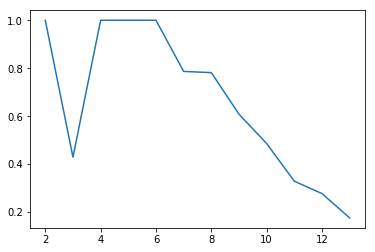

In [79]:
%matplotlib inline

y_28 =  df.loc[df['Samples'] == 28]
x_28 = y_28['Clusters']
plt.plot(x_28, y_28["MInfo"])
plt.show()


### 200 Samples, 40 clusters maximum

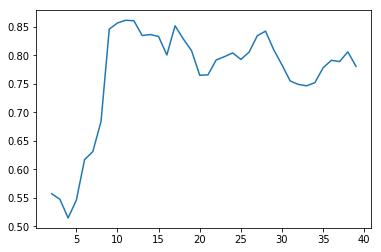

In [83]:
%matplotlib inline

y_200 =  df.loc[df['Samples'] == 200]
x_200 = y_200['Clusters']
plt.plot(x_200, y_200["MInfo"])
plt.show()

### 1414 Samples, 40 clusters maximum

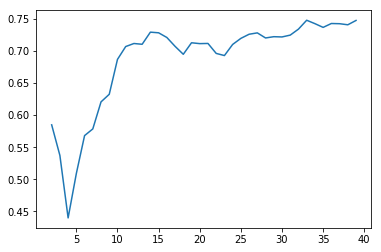

In [85]:
%matplotlib inline

y_200 =  df.loc[df['Samples'] == 1414]
x_200 = y_200['Clusters']
plt.plot(x_200, y_200["MInfo"])
plt.show()

### 10000 Samples, 13 clusters maximum

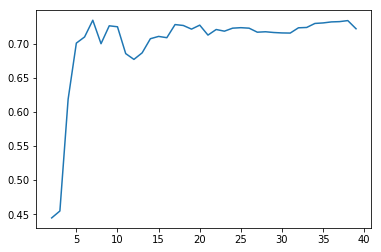

In [86]:
%matplotlib inline

y_200 =  df.loc[df['Samples'] == 10000]
x_200 = y_200['Clusters']
plt.plot(x_200, y_200["MInfo"])
plt.show()

#### Best result seems to be when using 10000 samples, with 7 clusters, with a MI score of 0.73

In [ ]:
---

In [110]:
# result = gridsearch(2,1,500)
N_CLUSTERS = 7 #result[0]
# HiMI = #result[1]

In [111]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

/home/rlourenco/miniconda3/envs/clouds-analysis-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:764: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [112]:
data = analysis.AEData(load_data(DATA, encoder.input_shape[1:]), n=10000)
data.add_encoder(encoder)

In [116]:
m1 = AgglomerativeClustering(n_clusters=N_CLUSTERS)
m1.fit(data.encs[:5000])
ag1 = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(data.encs[:5000])

m2 = AgglomerativeClustering(n_clusters=N_CLUSTERS)
m2.fit(data.encs)
ag2 = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(data.encs)

Mutual Information score:  0.6206798587783726


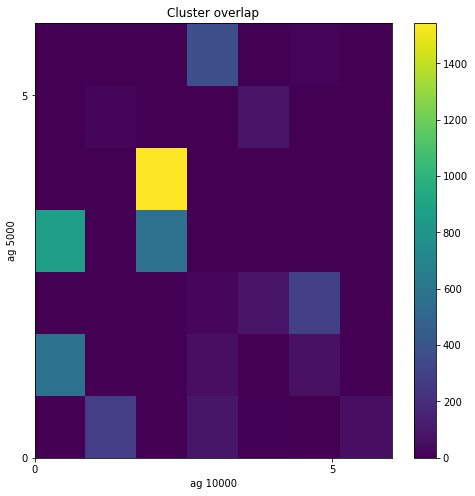

In [117]:
# Number of bins
nbins=N_CLUSTERS

plt.figure(figsize=(8,8))
plt.hist2d(ag1, ag2[:5000], bins=nbins);
plt.title("Cluster overlap")
plt.xticks(range(0, nbins, 5)); plt.yticks(range(0, nbins, 5));
plt.xlabel("ag 10000"); plt.ylabel("ag 5000");
plt.colorbar()
print('Mutual Information score: ',sklearn.metrics.adjusted_mutual_info_score(ag1, ag2[:5000]))

In [118]:
overlap = data.imgs[:5000,:,:,0][ag1 == ag2[:5000]]
overlap_c = ag1[ag1 == ag2[:5000]]



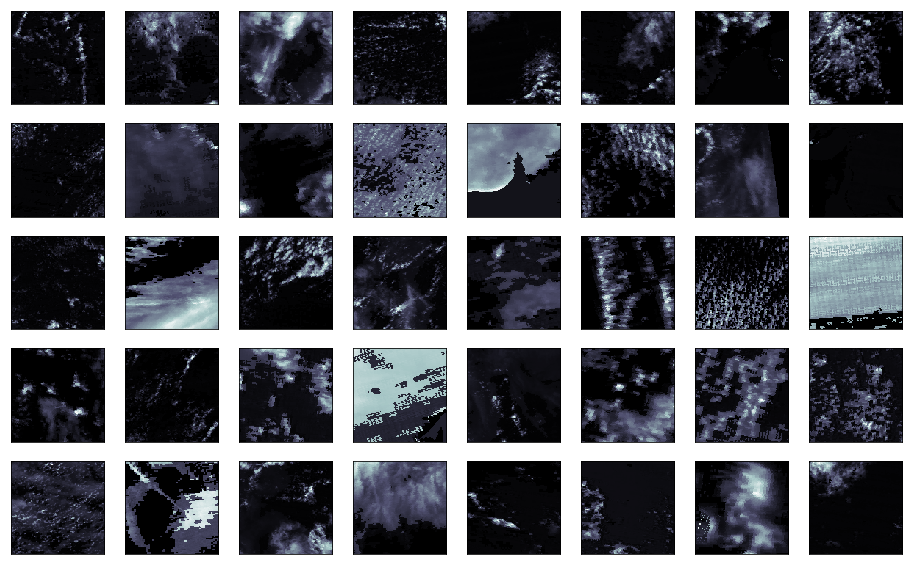

In [124]:
fig, ax = plt.subplots(5, 8, figsize=(16, 10))

clu = data.imgs[:5000,:,:,0][ag1 == 2]

for i, a in enumerate(ax.ravel()):
    a.imshow(clu[i], cmap="bone")
    a.set_xticks([])
    a.set_yticks([])



In [120]:

from scipy.cluster.hierarchy import dendrogram

In [121]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



That's hard to interpretate...

In [123]:
plt.figure(figsize=(500,100))
plot_dendrogram(m2, labels=m2.labels_)